<a href="https://colab.research.google.com/github/pedrogengo/DLforNLP/blob/main/Pedro_Gengo_Aula_6_Exerc%C3%ADcio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook de referência 

Nome: Pedro Gabriel Gengo Lourenço

In [ ]:
!pip install neptune-client

     |████████████████████████████████| 269 kB 4.1 MB/s 
     |████████████████████████████████| 829 kB 43.9 MB/s 
     |████████████████████████████████| 52 kB 1.5 MB/s 
     |████████████████████████████████| 180 kB 44.3 MB/s 
     |████████████████████████████████| 131 kB 50.2 MB/s 
     |████████████████████████████████| 7.9 MB 33.3 MB/s 
     |████████████████████████████████| 79 kB 8.1 MB/s 
     |████████████████████████████████| 138 kB 36.2 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 127 kB 51.9 MB/s 
     |████████████████████████████████| 67 kB 6.4 MB/s 
     |████████████████████████████████| 129 kB 47.7 MB/s 
  Created wheel for neptune-client: filename=neptune_client-0.11.0-py2.py3-none-any.whl size=465814 sha256=7a60e080b7710c7b871666886aa17c8c6da1d81bc797d671bbdb0ce2228f9038
  Stored in directory: /root/.cache/pip/wheels/3f/8e/62/53218bb22af6023b996288f379ea4844718519ba0f2acdf7b0
  Created wheel for future: filena

## Definindo os parametros

In [ ]:
params = {
    'vocabulary_size': 10000
}

# Fixando a seed

In [ ]:
import random
import torch
import numpy as np
import math
from torch.utils.data import Dataset, DataLoader

import neptune.new as neptune

In [ ]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

## Preparando Dados

Primeiro, fazemos download do dataset:

In [ ]:
!wget -nc http://files.fast.ai/data/aclImdb.tgz 
!tar -xzf aclImdb.tgz

--2021-09-23 10:59:04--  http://files.fast.ai/data/aclImdb.tgz
Resolving files.fast.ai (files.fast.ai)... 104.26.3.19, 172.67.69.159, 104.26.2.19, ...
Connecting to files.fast.ai (files.fast.ai)|104.26.3.19|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://files.fast.ai/data/aclImdb.tgz [following]
--2021-09-23 10:59:04--  https://files.fast.ai/data/aclImdb.tgz
Connecting to files.fast.ai (files.fast.ai)|104.26.3.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 145982645 (139M) [application/x-gtar-compressed]
Saving to: ‘aclImdb.tgz’

aclImdb.tgz         100%[===================>] 139.22M  9.41MB/s    in 16s     

2021-09-23 10:59:21 (8.80 MB/s) - ‘aclImdb.tgz’ saved [145982645/145982645]



## Carregando o dataset

Criaremos uma divisão de treino (24k exemplos) e validação (1k exemplos) artificialmente.

Nota: Evitar de olhar ao máximo o dataset de teste para não ficar enviseado no que será testado. Em aplicações reais, o dataset de teste só estará disponível no futuro, ou seja, é quando o usuário começa a testar o seu produto.

Neste exercicio, iremos usar apenas 1000 exemplos de validação e 1000 de teste pois precisamos executar uma inferencia do modelo para cada _palavra_ do dataset.

Como o aprendizado é não supervisionado, não iremos utilizar os rótulos.

In [ ]:
import os
import random


max_valid = 1000
max_test = 1000


def load_texts(folder):
    texts = []
    for path in os.listdir(folder):
        with open(os.path.join(folder, path)) as f:
            texts.append(f.read())
    return texts

x_train_pos = load_texts('aclImdb/train/pos')
x_train_neg = load_texts('aclImdb/train/neg')
x_test_pos = load_texts('aclImdb/test/pos')
x_test_neg = load_texts('aclImdb/test/neg')

x_train = x_train_pos + x_train_neg
x_test = x_test_pos + x_test_neg
y_train = [True] * len(x_train_pos) + [False] * len(x_train_neg)
y_test = [True] * len(x_test_pos) + [False] * len(x_test_neg)

# Embaralhamos o treino para depois fazermos a divisão treino/valid.
c = list(zip(x_train, y_train))
random.shuffle(c)
x_train, y_train = zip(*c)

x_valid = x_train[-max_valid:]
y_valid = y_train[-max_valid:]
x_train = x_train[:-max_valid]
y_train = y_train[:-max_valid]

# Embaralhamos o teste para diminuir a chance de algum viés nos 1000 exemplos amostrados.
c = list(zip(x_test, x_test))
random.shuffle(c)
x_test, x_test = zip(*c)
x_test = x_test[:max_test]
y_test = y_test[:max_test]

print(len(x_train), 'amostras de treino.')
print(len(x_valid), 'amostras de desenvolvimento.')
print(len(x_test), 'amostras de teste.')

print('3 primeiras amostras treino:')
for x, y in zip(x_train[:3], y_train[:3]):
    print(y, x[:100])

print('3 últimas amostras treino:')
for x, y in zip(x_train[-3:], y_train[-3:]):
    print(y, x[:100])

print('3 primeiras amostras validação:')
for x, y in zip(x_valid[:3], y_test[:3]):
    print(y, x[:100])

print('3 últimas amostras validação:')
for x, y in zip(x_valid[-3:], y_valid[-3:]):
    print(y, x[:100])

24000 amostras de treino.
1000 amostras de desenvolvimento.
1000 amostras de teste.
3 primeiras amostras treino:
False I wholeheartedly disagree with the other viewers of this wretched film. The only reason why I didn't
False This film is really terrible. terrible as in it is a waste of 84 minutes of your life. Special effec
True I realize that alot of people hate this movie, but i must admit that it is one of my favorites. I ha
3 últimas amostras treino:
False Yet another forgettable Warners foreign intrigue "thriller," this is rendered even less enjoyable by
False Cliché-ridden story of an impending divorce - or is it? - through the eyes of a 6 year-old child. Co
False Okay, so the previews to this film only tells you that a rebellious young girl goes to live with her
3 primeiras amostras validação:
True I do agree that though this story by Melville just might be unfilmable, this isn't even a credible t
True Very Slight Spoiler<br /><br /> This movie (despite being only on TV) is abs

In [ ]:
print(f'Numero de palavras treino: {sum([len(item.split()) for item in x_train])}')
print(f'Numero de palavras validação: {sum([len(item.split()) for item in x_valid])}')
print(f'Numero de palavras teste: {sum([len(item.split()) for item in x_test])}')

Numero de palavras treino: 5611955
Numero de palavras validação: 232725
Numero de palavras teste: 226558


# Definindo o vocabulário

Nessa etapa, definimos o vocabulário que será utilizado em todo o notebook. Para isso, passamos como limite de palavras o parâmetro configurado no início do notebook: *vocabulary_size*. Também definimos a função tokenize, que transforma um texto em uma lista de tokens unitários, caso esses tokens existam no vocabulário.

In [ ]:
import collections
import re


def tokenize(text, vocabulary=None):
    return [token.lower() for token in re.compile('\w+').findall(text) if vocabulary is None or vocabulary.get(token.lower()) is not None]


vocabulary = collections.Counter([token for text in x_train for token in tokenize(text)]).most_common(params['vocabulary_size'])
vocabulary = list(dict(vocabulary).keys())
print('top 20 tokens do vocabulário:')
print('\n'.join(vocabulary[:20]))

vocabulary = {token: i for i, token in enumerate(vocabulary)}

top 20 tokens do vocabulário:
the
and
a
of
to
is
br
it
in
i
this
that
s
was
as
for
with
movie
but
film


# Criando os datasets

Para o treinamento do Word2Vec (CBOW), é necessário que nosso conjunto de treinamento seja formado por:

- target: tokens que queremos prever dado sua vizinhança;
- features: lista de tokens passados e futuros do token target.

Ou seja, precisamos criar uma janela em cima do token target. Dessa forma, na definição da classe Dataset que será usada no experimento, o que foi feito foi aplicar o conceito de "convolução" de redes convolucionais, para o cenário de texto. Um ponto muito importante é: o conjunto total *features + target* sempre terá tamanho ímpar.

In [ ]:
def unify_text(texts, vocabulary=None):
  flatten_texts = []
  for text in texts:
    flatten_texts.extend(tokenize(text, vocabulary))
  return flatten_texts

In [ ]:
class DatasetSlidingWindow(Dataset):
  def __init__(self, window_size, vocab, flatten_tokens):
    self.window_size = window_size // 2
    self.vocab = vocab
    self.flatten_tokens = flatten_tokens
  
  def __len__(self):
    return len(self.flatten_tokens) - self.window_size * 2

  def __getitem__(self, idx):
    x = self.flatten_tokens[idx: idx + self.window_size] + self.flatten_tokens[idx + self.window_size + 1: idx + 2 * self.window_size + 1]
    x = [self.vocab[el] for el in x]
    y = self.flatten_tokens[idx + self.window_size]
    y = self.vocab[y]
    return torch.tensor(x).long(), torch.tensor(y).long()


# Definindo perplexidade

A perplexidade pode ser definida como sendo o exponencial da entropia cruzada total. Poderia ser aplicado diretamente ao código, porém, por uma questão de facilidade de leitura do loop de treino, validação e teste, optei por criar uma função com o nome apropriado.

In [ ]:
def perplexity(crossentropy_sum):
  return math.exp(crossentropy_sum)

# Loops de treino, validação e teste

In [ ]:
run = neptune.init(
    project="pedro.gengo/IA-376",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxZjYyNDA1MS1hZDJlLTRiZDctYjIxNy0xMTNhY2FmNzZhYmIifQ==",
)

https://app.neptune.ai/pedro.gengo/IA-376/e/IA-15
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [ ]:
if torch.cuda.is_available(): 
   dev = "cuda:0"
   print(torch. cuda. get_device_name(dev))
else: 
   dev = "cpu" 
print(dev)
device = torch.device(dev)

Tesla K80
cuda:0


In [ ]:
def train(model, train, valid, criterion, optimizer, filename_save, len_tokens_valid, n_epochs=10):
  
  best_valid_loss = 10e9
  best_epoch = 0
  train_losses, valid_losses, valid_perplexities = [], [], []
  for i in range(n_epochs):
    accumulated_loss = 0
    model.train()
    for x_train, y_train in train:
      x_train = x_train.to(device)
      y_train = y_train.to(device)
      outputs = model(x_train)
      batch_loss = criterion(outputs, y_train)

      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()
      accumulated_loss += batch_loss.item()
    train_loss = accumulated_loss / len(train.dataset)
    run[f"{filename_save}_train/loss"].log(train_loss)
    train_losses.append(train_loss)

    # Laço de Validação, um a cada época.
    accumulated_loss = 0
    accumulated_accuracy = 0
    model.eval()
    with torch.no_grad():
        for x_valid, y_valid in valid:
            x_valid = x_valid.to(device)
            y_valid = y_valid.to(device)

            # predict da rede
            outputs = model(x_valid)

            # calcula a perda
            batch_loss = criterion(outputs, y_valid)

            # calcula a acurácia
            accumulated_loss += batch_loss.item()
    
    valid_loss = accumulated_loss / len_tokens_valid
    run[f"{filename_save}_valid/loss"].log(valid_loss)
    valid_losses.append(valid_loss)

    valid_perplexity = perplexity(valid_loss)
    run[f"{filename_save}_valid/ppl"].log(valid_perplexity)

    print(f'Época: {i:d}/{n_epochs - 1:d} Train Loss: {train_loss:.6f} Valid Loss: {valid_loss:.6f} Valid Ppl: {valid_perplexity:.3f}')

    # Salvando o melhor modelo de acordo com a loss de validação
    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), filename_save + '.pt')
        best_valid_loss = valid_loss
        best_epoch = i
        print('best model')

  return model, train_losses, valid_losses

In [ ]:
def predict(model, state_dict, test, tokens_test):
  accumulated_loss = 0
  model.load_state_dict(torch.load(state_dict + '.pt'))
  model.eval()
  with torch.no_grad():
      for x_test, y_test in test:
          x_test = x_test.to(device)
          y_test = y_test.to(device)

          # predict da rede
          outputs = model(x_test)

          # calcula a perda
          batch_loss = criterion(outputs, y_test)
          
          accumulated_loss += batch_loss.item()

  total_loss = accumulated_loss / tokens_test
  ppl = perplexity(total_loss)
  print('*' * 40)
  print(f'Perplexidade de {ppl:.3f}')
  print('*' * 40)

# Modelo

O modelo aqui definido é baseado na arquitetura CBOW, que podemos ver na figura abaixo. De forma resumida, temos uma camada de projeção, que é nossa cada de embeddings, seguida por uma camada de classificação (camada linear).

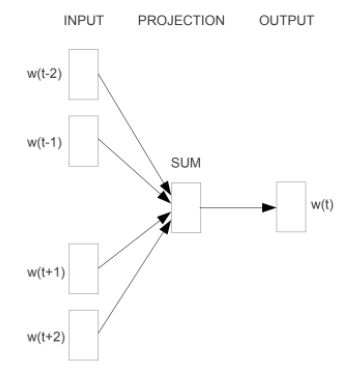



In [ ]:
class CBOW(torch.nn.Module):
  def __init__(self, emb_size, vocab_size):
    super(CBOW, self).__init__()
    self.embedding = torch.nn.Embedding(vocab_size, emb_size)
    self.linear = torch.nn.Linear(emb_size, vocab_size)
  
  def forward(self, x):
    x = self.embedding(x).sum(dim=1)
    x = self.linear(x)
    return x

# Experimento

## Hiperparâmetros

In [ ]:
learning_rate = 0.001
n_epochs = 10
batch_size = 128
emb_size = 300
window_size = 5

hprams = {"learning_rate": learning_rate,
          "window_size": window_size,
          "batch_size":batch_size,
          "emb_size": emb_size}

## Validando o fluxo

Utilizando apenas um pequeno conjunto do dataset completo, irei excutar o fluxo de treino completo para validar a execução e comportamento dos resultados.

In [ ]:
dataset_train = DatasetSlidingWindow(window_size, vocabulary, unify_text(x_train[:100], vocabulary))
dataset_valid = DatasetSlidingWindow(window_size, vocabulary, unify_text(x_valid[:50], vocabulary))
dataset_test = DatasetSlidingWindow(window_size, vocabulary, unify_text(x_test, vocabulary))

dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [ ]:
cbow = CBOW(emb_size, len(vocabulary))
cbow.to(device)

CBOW(
  (embedding): Embedding(10000, 300)
  (linear): Linear(in_features=300, out_features=10000, bias=True)
)

In [ ]:
criterion = torch.nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(cbow.parameters(), lr=learning_rate)

_ = train(cbow, dataloader_train, dataloader_valid, criterion, optimizer, 'cbow', len(unify_text(x_valid[:50], vocabulary)), n_epochs)

Época: 0/9 Train Loss: 7.863433 Valid Loss: 7.448103 Valid Ppl: 1716.603
best model
Época: 1/9 Train Loss: 5.412900 Valid Loss: 7.356866 Valid Ppl: 1566.919
best model
Época: 2/9 Train Loss: 4.105319 Valid Loss: 7.465791 Valid Ppl: 1747.237
Época: 3/9 Train Loss: 3.278065 Valid Loss: 7.619134 Valid Ppl: 2036.797
Época: 4/9 Train Loss: 2.768173 Valid Loss: 7.771484 Valid Ppl: 2371.989
Época: 5/9 Train Loss: 2.401448 Valid Loss: 7.920948 Valid Ppl: 2754.380
Época: 6/9 Train Loss: 2.123911 Valid Loss: 8.075565 Valid Ppl: 3214.943
Época: 7/9 Train Loss: 1.899094 Valid Loss: 8.217910 Valid Ppl: 3706.747
Época: 8/9 Train Loss: 1.713157 Valid Loss: 8.365670 Valid Ppl: 4296.990
Época: 9/9 Train Loss: 1.551892 Valid Loss: 8.519005 Valid Ppl: 5009.068


## Experimento final

In [ ]:
dataset_train = DatasetSlidingWindow(window_size, vocabulary, unify_text(x_train, vocabulary))
dataset_valid = DatasetSlidingWindow(window_size, vocabulary, unify_text(x_valid, vocabulary))
dataset_test = DatasetSlidingWindow(window_size, vocabulary, unify_text(x_test, vocabulary))

dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [ ]:
cbow = CBOW(emb_size, len(vocabulary))
cbow.to(device)

CBOW(
  (embedding): Embedding(10000, 300)
  (linear): Linear(in_features=300, out_features=10000, bias=True)
)

In [ ]:
criterion = torch.nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(cbow.parameters(), lr=learning_rate)

_ = train(cbow, dataloader_train, dataloader_valid, criterion, optimizer, 'cbow', len(unify_text(x_valid, vocabulary)), n_epochs)

Época: 0/9 Train Loss: 5.632504 Valid Loss: 5.422756 Valid Ppl: 226.503
best model
Época: 1/9 Train Loss: 5.220908 Valid Loss: 5.326257 Valid Ppl: 205.667
best model
Época: 2/9 Train Loss: 5.075302 Valid Loss: 5.282997 Valid Ppl: 196.959
best model
Época: 3/9 Train Loss: 4.980142 Valid Loss: 5.259907 Valid Ppl: 192.464
best model
Época: 4/9 Train Loss: 4.910263 Valid Loss: 5.251431 Valid Ppl: 190.839
best model
Época: 5/9 Train Loss: 4.856976 Valid Loss: 5.248691 Valid Ppl: 190.317
best model
Época: 6/9 Train Loss: 4.815394 Valid Loss: 5.247158 Valid Ppl: 190.025
best model
Época: 7/9 Train Loss: 4.781734 Valid Loss: 5.248794 Valid Ppl: 190.337
Época: 8/9 Train Loss: 4.755272 Valid Loss: 5.247340 Valid Ppl: 190.060
Época: 9/9 Train Loss: 4.733733 Valid Loss: 5.250761 Valid Ppl: 190.711


In [ ]:
predict(cbow, 'cbow', dataloader_test, len(unify_text(x_test, vocabulary)))

****************************************
Perplexidade de 198.280
****************************************


## Avaliação algébrica dos vetores

In [ ]:
emb_weights = cbow.embedding.weight

In [ ]:
def find_similar_embeddings(word_vector, n, emb_weights, vocab):
  distances = []
  for i in range(emb_weights.shape[0]):
      sim = torch.cosine_similarity(word_vector, emb_weights[i], dim=0).item()
      distances.append((vocab[i], sim))

  return sorted(distances, key=lambda x: x[1], reverse=True)[:n]

In [ ]:
vocab_idx_to_word = {value: key for key, value in vocabulary.items()}
find_similar_embeddings(emb_weights[vocabulary['car']], 5, emb_weights, vocab_idx_to_word)

[('car', 1.0),
 ('truck', 0.3475690186023712),
 ('plane', 0.3317131996154785),
 ('bus', 0.32689565420150757),
 ('train', 0.3259400427341461)]

In [ ]:
possib_queen = emb_weights[vocabulary['king']] - emb_weights[vocabulary['man']] + emb_weights[vocabulary['woman']]
find_similar_embeddings(possib_queen, 5, emb_weights, vocab_idx_to_word)

[('king', 0.7818091511726379),
 ('woman', 0.40075036883354187),
 ('dickens', 0.273348331451416),
 ('writer', 0.2671816051006317),
 ('wife', 0.248124361038208)]

In [ ]:
possib_queen = emb_weights[vocabulary['best']] - emb_weights[vocabulary['good']] + emb_weights[vocabulary['bad']]
find_similar_embeddings(possib_queen, 5, emb_weights, vocab_idx_to_word)

[('best', 0.7514254450798035),
 ('worst', 0.5503748655319214),
 ('bad', 0.38615408539772034),
 ('greatest', 0.382972776889801),
 ('scariest', 0.3725852370262146)]